In [102]:
# imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import norm
from scipy.optimize import linear_sum_assignment
from tqdm.notebook import tqdm
from scipy.interpolate import interp2d
import cv2

import pickle
import warnings
warnings.filterwarnings('ignore')

# PARAMETERS
FRAME_RATE = 10
MINIMUM_TRACK_LENGTH = 10 # minimum number of frames a track must have to be considered
DIMENSION = [1944, 1944] # dimensions of the image
pose_markers = ['tip_of_head', 'antennaL', 'antennaR', 'petiole', 'ovipositor']
RECALCULATE = False

# make plots interactive
%matplotlib qt

In [103]:
# data loading
data_folder = '../data/vikram_raiding_data/sleap_prediction_round1'
database = {}
for data_file in list(filter(lambda x: x.endswith('.csv'), os.listdir(data_folder))):
    database[data_file] = {}
    database[data_file]['tracking_data'] = pd.read_csv(os.path.join(data_folder, data_file))

In [104]:
def get_tracks(tracking_data):
    '''
    Get all unique tracks from the data, and return them as a list of dataframes
    '''
    tracks = tracking_data['track'].unique()
    return [tracking_data[tracking_data['track'] == track] for track in tracks]

def simple_interpolate_track(track, pose_markers):
    '''
    Interpolate the track to fill in missing values
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    for marker in pose_markers:
        track.loc[:, marker + '.x'] = track[marker + '.x'].infer_objects(copy=False).interpolate()
        track.loc[:, marker + '.y'] = track[marker + '.y'].infer_objects(copy=False).interpolate()
    # fill each end with the first and last values
    for marker in pose_markers:
        track.loc[:, marker + '.x'] = track[marker + '.x'].fillna(method='bfill').fillna(method='ffill')
        track.loc[:, marker + '.y'] = track[marker + '.y'].fillna(method='bfill').fillna(method='ffill')
    return track

def calculate_time(track):
    '''
    Calculate the time at each frame in the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the time
    track.loc[:, 'time'] = track['frame_idx'] / FRAME_RATE
    return track

def calculate_centroid(track, pose_markers): 
    '''
    Calculate the centroid position at each frame in the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    centroid_x = np.nanmean([track[marker + '.x'] for marker in pose_markers], axis=0)
    centroid_y = np.nanmean([track[marker + '.y'] for marker in pose_markers], axis=0)
    # add to the track
    track.loc[:, 'centroid.x'] = centroid_x
    track.loc[:, 'centroid.y'] = centroid_y
    return track

def calculate_velocity(track, pose_markers=None):
    '''
    Calculate the velocity at each frame in the track
    '''
    assert all([col in track.columns for col in ['centroid.x', 'centroid.y']]), 'Track does not have centroid position'
    if pose_markers is not None:
        assert all([col in track.columns for col in [pm + '.x' for pm in pose_markers] + [pm + '.y' for pm in pose_markers]]), 'Track does not have pose markers'

    # make sure the track is long enough
    if len(track) < MINIMUM_TRACK_LENGTH:
        return None

    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the velocity
    velocity_x = np.diff(track['centroid.x'])
    velocity_y = np.diff(track['centroid.y'])
    velocity = np.sqrt(velocity_x**2 + velocity_y**2)
    delta_t = np.diff(track['time'])
    velocity = np.where(delta_t > 0, velocity / delta_t, np.nan)
    # add to the track
    track.loc[1:, 'velocity'] = velocity
    # calculate the angle
    angle = np.arctan2(velocity_y, velocity_x)
    track.loc[1:, 'angle'] = angle

    # calculate the velocity of each pose marker
    if pose_markers is not None:
        for marker in pose_markers:
            velocity_x = np.diff(track[marker + '.x'])
            velocity_y = np.diff(track[marker + '.y'])
            velocity = np.sqrt(velocity_x**2 + velocity_y**2)
            delta_t = np.diff(track['frame_idx'])/FRAME_RATE
            velocity = velocity / delta_t
            # add to the track
            track.loc[1:, marker + '.velocity'] = velocity
            # calculate the angle
            angle = np.arctan2(velocity_y, velocity_x)
            track.loc[1:, marker + '.angle'] = angle

    # remove the last frame
    track = track.iloc[:-1]
    return track

def uniform_interpolate_track(track):
    '''
    Interpolate the track to fill in missing values including missing frames
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # get smallest and largest frame index
    min_frame_idx = track['frame_idx'].min()
    max_frame_idx = track['frame_idx'].max()
    # add missing frames
    for frame_idx in range(min_frame_idx, max_frame_idx):
        if frame_idx not in track['frame_idx'].values:
            # add a new row using concatenation
            new_row = pd.DataFrame({'frame_idx': [frame_idx]})
            track = pd.concat([track, new_row], ignore_index=True)
    # sort by frame index
    track = track.sort_values('frame_idx').reset_index(drop=True)
    # interpolate all columns
    for col in track.columns:
        if col == 'frame_idx':
            continue
        track.loc[:, col] = track[col].infer_objects(copy=False).interpolate()
    return track

In [105]:
# check if cleaned data pickle exists
if os.path.exists('../data/vikram_raiding_data/sleap_prediction_round1/cleaned_database.pkl') and not RECALCULATE:
    with open('../data/vikram_raiding_data/sleap_prediction_round1/cleaned_database.pkl', 'rb') as f:
        database = pickle.load(f)
    print('Loaded cleaned data from pickle')
else:
    # for each video, get all tracks
    for data_file in database.keys():
        database[data_file]['tracks'] = get_tracks(database[data_file]['tracking_data'])

    # for each video, calculate the centroid and velocity for each track
    for data_file in database.keys():
        update_tracks = []
        for track in database[data_file]['tracks']:
            track = calculate_time(track)
            track = simple_interpolate_track(track, pose_markers)
            track = calculate_centroid(track, pose_markers)
            track = calculate_velocity(track)
            if track is not None:
                update_tracks.append(track)
        database[data_file]['tracks'] = update_tracks

    # for each video, get the distribution of velocities to calculate the threshold
    for data_file in database.keys():
        velocities = []
        for track in database[data_file]['tracks']:
            velocities.extend(track['velocity'].values)
        # get the 95th percentile of the velocities
        database[data_file]['velocity_threshold'] = np.nanpercentile(velocities, 95)
        print(f'{data_file}: {database[data_file]["velocity_threshold"]}')

    # for each video, clean the tracks by splitting them at high velocity points
    for data_file in database.keys():
        update_tracks = []
        segment_number = 0
        print(f'{data_file}: cleaning tracks; {len(database[data_file]["tracks"])} tracks found')
        for track in database[data_file]['tracks']:
            # split the track at high velocity points
            split_points = np.where(track['velocity'] > database[data_file]['velocity_threshold'])[0]
            # also add any points where the marker velocity is high
            for marker in pose_markers:
                split_points = np.concatenate((split_points, np.where(track[marker + '.velocity'] > database[data_file]['velocity_threshold'])[0]))
            # remove duplicates
            split_points = np.unique(split_points)
            if len(split_points) == 0:
                update_tracks.append(track)
            else:
                split_points = np.concatenate(([0], split_points, [len(track)]))
                for i in range(len(split_points) - 1):
                    # get the track segment
                    segment = track.iloc[split_points[i]:split_points[i+1]].copy().reset_index(drop=True)
                    # remove high velocity points
                    segment = segment[segment['velocity'] < database[data_file]['velocity_threshold']].reset_index(drop=True)
                    # get the length of the segment
                    if len(segment) < MINIMUM_TRACK_LENGTH:
                        continue
                    # add the segment number
                    segment.loc[:, 'segment'] = segment_number
                    # uniform interpolate the segment
                    segment = uniform_interpolate_track(segment)
                    segment_number += 1
                    update_tracks.append(segment)
        print(f'{data_file}: {len(update_tracks)} tracks after cleaning')
        database[data_file]['tracks'] = update_tracks

    # save the cleaned data to a pickle
    with open('../data/vikram_raiding_data/sleap_prediction_round1/cleaned_database.pkl', 'wb') as f:
        pickle.dump(database, f)
        

Loaded cleaned data from pickle


In [109]:
def calculate_body_axis(track, body_pose_markers):
    '''
    Calculate the body axis of the track
    '''
    assert len(body_pose_markers) == 2, 'Body axis calculation requires two pose markers'
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the body axis length
    body_axis_x = track[body_pose_markers[1] + '.x'] - track[body_pose_markers[0] + '.x']
    body_axis_y = track[body_pose_markers[1] + '.y'] - track[body_pose_markers[0] + '.y']
    body_axis_length = np.sqrt(body_axis_x**2 + body_axis_y**2)
    # calculate the body axis angle
    body_axis_angle = np.arctan2(body_axis_y, body_axis_x)
    # add to the track
    track.loc[:, 'body_length'] = body_axis_length
    track.loc[:, 'body_angle'] = body_axis_angle
    return track

def calculate_angular_velocity(track, body_pose_markers):
    '''
    Calculate the relative angular velocity of the track
    '''
    assert len(body_pose_markers) == 2, 'Relative angular velocity calculation requires two pose markers'
    assert all([col in track.columns for col in ['body_length', 'body_angle']]), 'Track does not have body axis'
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the relative angular velocity
    angular_velocity = np.diff(track['body_angle'])
    delta_t = np.diff(track['time'])
    angular_velocity = np.where(delta_t > 0, angular_velocity / delta_t, np.nan)
    # add to the track
    track.loc[:, 'angular_velocity'] = np.concatenate(([np.nan], angular_velocity))
    return track

In [110]:
# for each video, calculate the body axis and angular velocity for each track
for data_file in database.keys():
    update_tracks = []
    for track in database[data_file]['tracks']:
        track = calculate_body_axis(track, ['petiole', 'tip_of_head'])
        track = calculate_angular_velocity(track, ['petiole', 'tip_of_head'])
        update_tracks.append(track)
    database[data_file]['tracks'] = update_tracks

In [111]:
# for each video, plot the tracks
fig, axes = plt.subplots(1, len(database), figsize=(20, 5))
for i, data_file in enumerate(database.keys()):
    ax = axes[i]
    for track in database[data_file]['tracks']:
        ax.plot(track['centroid.x'], track['centroid.y'], '-', alpha=1, lw=0.5, color=plt.cm.magma(np.random.uniform(0, 1)))
    ax.set_xlim(0, DIMENSION[0])
    ax.set_ylim(0, DIMENSION[1])
    ax.axis('off')
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [112]:
# get all angular velocities to calculate the distribution
angular_velocities = []
for data_file in database.keys():
    for track in database[data_file]['tracks']:
        angular_velocities.extend(track['angular_velocity'].values)
angular_velocities = np.array(angular_velocities)
angular_velocities = angular_velocities[~np.isnan(angular_velocities)]
# plot the distribution of angular velocities
fig, ax = plt.subplots()
ax.hist(angular_velocities, bins=100, density=True)
# plot lines at -40, -20, 20, 40
ax.axvline(-40, color='r', linestyle='--')
ax.axvline(-20, color='r', linestyle='--')
ax.axvline(20, color='r', linestyle='--')
ax.axvline(40, color='r', linestyle='--')
ax.set_xlabel('Angular velocity (rad/s)')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()
# get min and max angular velocities
min_angular_velocity = angular_velocities.min()
max_angular_velocity = angular_velocities.max()


In [113]:
# classify all frames 3 states, forward-facing; smooth-turn; sharp-turn
def classify_angular_motion(track):
    '''
    Classify the angular motion of the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # classify the angular motion 
    # (0) |v| < 20 rad/s as forward-facing; 
    # (1) 20 < |v| < 40 rad/s as smooth-turn; 
    # (2) |v| > 40 rad/s as sharp-turn
    # we will also save a turn direction (1 for right, -1 for left)
    turn_direction = np.sign(track['angular_velocity'])
    track.loc[:, 'angular_motion'] = np.where(np.abs(track['angular_velocity']) < 20, 0, 
                                              np.where(np.abs(track['angular_velocity']) < 40, 1, 2))
    track.loc[:, 'turn_direction'] = turn_direction
    return track

def calculate_average_future_turn_direction(track, window_size=0.5):
    '''
    Calculate the average future turn direction of the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the average future turn direction
    average_future_turn_direction = np.zeros(len(track))
    # turn window size into frames from seconds
    window_size = int(window_size * FRAME_RATE)
    for i in range(len(track)):
        future_turn_direction = track['turn_direction'].iloc[i:i+window_size].mean()
        average_future_turn_direction[i] = future_turn_direction
    # add to the track
    track.loc[:, 'average_future_turn_direction'] = average_future_turn_direction
    return track

# for each video, classify the angular motion and calculate the average future turn direction for each track
for data_file in database.keys():
    update_tracks = []
    for track in database[data_file]['tracks']:
        track = classify_angular_motion(track)
        track = calculate_average_future_turn_direction(track)
        update_tracks.append(track)
    database[data_file]['tracks'] = update_tracks


In [114]:
# create a now cleaned tracking data dataframe
for data_file in database.keys():
    cleaned_data = pd.concat(database[data_file]['tracks'])
    # sort the data by frame index
    cleaned_data = cleaned_data.sort_values(by='frame_idx').reset_index(drop=True)
    # add the data to the database
    database[data_file]['cleaned_data'] = cleaned_data
    print(f'{data_file}: {len(cleaned_data)} frames after cleaning')

labels.v001.001_2018_05_25_19_58_cam_4_1.analysis.csv: 8127 frames after cleaning
labels.v001.000_2018_05_22_09_53_cam_0_1.analysis.csv: 14785 frames after cleaning
labels.v001.005_2018_05_25_19_58_cam_6_1.analysis.csv: 9873 frames after cleaning
labels.v001.006_2018_05_25_19_58_cam_6_3.analysis.csv: 11608 frames after cleaning
labels.v001.002_2018_05_25_19_58_cam_4_2.analysis.csv: 7612 frames after cleaning
labels.v001.004_2018_05_25_19_58_cam_5_2.analysis.csv: 5892 frames after cleaning
labels.v001.003_2018_05_25_19_58_cam_4_3.analysis.csv: 4296 frames after cleaning


In [115]:
# get a sample cleaned data
cleaned_data = database[list(database.keys())[0]]['cleaned_data']

In [121]:
def estimate_trail_map(tracks, output_path, trail_props, antennal_pose_markers, body_pose_markers):
    '''
    Generates a trail map video from the cleaned data, using the provided trail properties and antennal pose markers.
    '''
    # generate the cleaned data
    cleaned_data = tracks.copy()
    cleaned_data = pd.concat(cleaned_data).sort_values('frame_idx').reset_index(drop=True)

    # Get average body length
    x_diff = cleaned_data[body_pose_markers[0] + '.x'] - cleaned_data[body_pose_markers[1] + '.x']
    y_diff = cleaned_data[body_pose_markers[0] + '.y'] - cleaned_data[body_pose_markers[1] + '.y']
    body_length = np.nanmean(np.sqrt(x_diff**2 + y_diff**2))

    # Set the spread of the trail in pixels
    sd = trail_props['spread'] * body_length

    # Get the maximum frame index
    max_frame = int(cleaned_data['frame_idx'].max())

    # Create the empty trail map
    trail_map = np.zeros(DIMENSION)

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, FRAME_RATE, (DIMENSION[0], DIMENSION[1]), isColor=False)

    # Loop over the frames
    for frame in tqdm(range(max_frame)):
        # Decay the trail map
        trail_map = trail_map * trail_props['decay'] ** (1 / FRAME_RATE)
        
        # Get the tracks at the current frame
        current_tracks = cleaned_data[cleaned_data['frame_idx'] == frame]
        
        # Get the position of the source
        source_x = current_tracks[trail_props['source'] + '.x'].values
        source_y = current_tracks[trail_props['source'] + '.y'].values

        # Add a 2D Gaussian to the trail map
        for x, y in zip(source_x, source_y):
            addition = norm.pdf(np.arange(DIMENSION[0]), x, sd)[:, None] * norm.pdf(np.arange(DIMENSION[1]), y, sd)
            # Normalize the addition
            addition = addition / addition.max()
            trail_map += addition

        # Get the indices of the cleaned data at the current frame
        indices = cleaned_data[cleaned_data['frame_idx'] == frame].index
        
        # Get the position of the antennae at the current frame
        antennae_x = cleaned_data.loc[indices, [marker + '.x' for marker in antennal_pose_markers]].values
        antennae_y = cleaned_data.loc[indices, [marker + '.y' for marker in antennal_pose_markers]].values

        # Loop over the indices and add the trail value to the cleaned data
        f = interp2d(np.arange(DIMENSION[0]), np.arange(DIMENSION[1]), trail_map)
        for i, idx in enumerate(indices):
            for j, marker in enumerate(antennal_pose_markers):
                x = int(np.clip(antennae_x[i, j], 0, DIMENSION[0] - 1))
                y = int(np.clip(antennae_y[i, j], 0, DIMENSION[1] - 1))
                # Interpolate the value of the trail map at the position of the antennae
                cleaned_data.loc[idx, marker + '.trail'] = trail_map[x, y]

        # Write the frame to the video in grayscale
        frame_to_write = (trail_map - trail_map.min()) / (trail_map.max() - trail_map.min()) * 255
        frame_to_write = frame_to_write.astype(np.uint8)

        # Draw the ants on the frame (all pose markers)
        for idx in indices:
            # Get the positions of the pose markers
            try:
                petiole = (int(cleaned_data.loc[idx, 'petiole.y']), int(cleaned_data.loc[idx, 'petiole.x']))
                frame_to_write = cv2.circle(frame_to_write, petiole, 5, 255, -1)
            except:
                pass

            try:
                tip_of_head = (int(cleaned_data.loc[idx, 'tip_of_head.y']), int(cleaned_data.loc[idx, 'tip_of_head.x']))
                frame_to_write = cv2.circle(frame_to_write, tip_of_head, 5, 255, -1)
            except:
                pass

            try:
                ovipositor = (int(cleaned_data.loc[idx, 'ovipositor.y']), int(cleaned_data.loc[idx, 'ovipositor.x']))
                frame_to_write = cv2.circle(frame_to_write, ovipositor, 5, 255, -1)
            except:
                pass

            try:
                antennaL = (int(cleaned_data.loc[idx, 'antennaL.y']), int(cleaned_data.loc[idx, 'antennaL.x']))
                size = int((cleaned_data.loc[idx, 'antennaL.trail'] - trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
                frame_to_write = cv2.circle(frame_to_write, antennaL, size, 255, -1)
            except:
                pass

            try:
                antennaR = (int(cleaned_data.loc[idx, 'antennaR.y']), int(cleaned_data.loc[idx, 'antennaR.x']))
                size = int((cleaned_data.loc[idx, 'antennaR.trail'] - trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
                frame_to_write = cv2.circle(frame_to_write, antennaR, size, 255, -1)
            except:
                pass

            # Draw lines connecting pose markers
            try:
                frame_to_write = cv2.line(frame_to_write, petiole, tip_of_head, 255, 1)
            except:
                pass

            try:
                frame_to_write = cv2.line(frame_to_write, petiole, ovipositor, 255, 1)
            except:
                pass

            try:
                frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaL, 255, 1)
            except:
                pass

            try:
                frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaR, 255, 1)
            except:
                pass

            # draw an arrow from the higher antennae to the lower antennae to indicate direction
            try:
                offset = 30
                # shift the points to the center of the ant
                petiole = (int(cleaned_data.loc[idx, 'petiole.y']), int(cleaned_data.loc[idx, 'petiole.x']))
                tip_of_head = (int(cleaned_data.loc[idx, 'tip_of_head.y']), int(cleaned_data.loc[idx, 'tip_of_head.x']))
                body_axis_unit_vector = np.array([tip_of_head[0] - petiole[0], tip_of_head[1] - petiole[1]])
                body_axis_unit_vector = body_axis_unit_vector / np.linalg.norm(body_axis_unit_vector)

                # get the antennae positions by shifting them to the center of the ant
                antennaL = (int(cleaned_data.loc[idx, 'antennaL.y']), int(cleaned_data.loc[idx, 'antennaL.x']))
                antennaR = (int(cleaned_data.loc[idx, 'antennaR.y']), int(cleaned_data.loc[idx, 'antennaR.x']))
                # move point along the body axis
                antennaL = (antennaL[0] + int(body_axis_unit_vector[0] * offset), antennaL[1] + int(body_axis_unit_vector[1] * offset))
                antennaR = (antennaR[0] + int(body_axis_unit_vector[0] * offset), antennaR[1] + int(body_axis_unit_vector[1] * offset))

                # draw the arrow for antennal difference
                if abs(cleaned_data.loc[idx, 'antennaR.trail'] - cleaned_data.loc[idx, 'antennaL.trail']) > 0.1:
                    if cleaned_data.loc[idx, 'antennaR.trail'] > cleaned_data.loc[idx, 'antennaL.trail']:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaL, antennaR, 255, 10, tipLength=0.5)
                    else:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaR, antennaL, 255, 10, tipLength=0.5)

                # shift the points another 10 pixels along the body axis
                antennaL = (antennaL[0] + int(body_axis_unit_vector[0] * offset), antennaL[1] + int(body_axis_unit_vector[1] * offset))
                antennaR = (antennaR[0] + int(body_axis_unit_vector[0] * offset), antennaR[1] + int(body_axis_unit_vector[1] * offset))

                # draw the arrow for average future turn direction
                if cleaned_data.loc[idx, 'average_future_turn_direction'] > 0:
                    frame_to_write = cv2.arrowedLine(frame_to_write, antennaL, antennaR, 127, 10, tipLength=0.5)
                else:
                    frame_to_write = cv2.arrowedLine(frame_to_write, antennaR, antennaL, 127, 10, tipLength=0.5)
            except:
                pass

        # Write the frame to the video
        out.write(frame_to_write.astype(np.uint8))

    # Release the video writer
    out.release()

    # convert back to tracks by segment number
    tracks = []
    for segment in cleaned_data['segment'].unique():
        track = cleaned_data[cleaned_data['segment'] == segment].copy()
        tracks.append(track)
    return tracks



In [122]:
# Example usage:
trail_props = {
    'source': 'ovipositor',
    'spread': 0.25,
    'decay': 1,
}
antennal_pose_markers = ['antennaL', 'antennaR']
body_pose_markers = ['ovipositor', 'tip_of_head']

# estimate the trail map for all videos and also save the trail map path
for data_file in database.keys():
    output_path = os.path.join(data_folder, data_file.replace('.csv', '_trail_map.mp4'))
    tracks = database[data_file]['tracks']
    tracks = estimate_trail_map(tracks, output_path, trail_props, antennal_pose_markers, body_pose_markers)
    # save the trail map path
    database[data_file]['trail_map'] = output_path
    # save the tracks
    database[data_file]['tracks'] = tracks
    print(f'{data_file}: Trail map generated')

  0%|          | 0/4829 [00:00<?, ?it/s]

labels.v001.001_2018_05_25_19_58_cam_4_1.analysis.csv: Trail map generated


  0%|          | 0/22549 [00:00<?, ?it/s]

labels.v001.000_2018_05_22_09_53_cam_0_1.analysis.csv: Trail map generated


  0%|          | 0/8423 [00:00<?, ?it/s]

labels.v001.005_2018_05_25_19_58_cam_6_1.analysis.csv: Trail map generated


  0%|          | 0/6268 [00:00<?, ?it/s]

labels.v001.006_2018_05_25_19_58_cam_6_3.analysis.csv: Trail map generated


  0%|          | 0/7925 [00:00<?, ?it/s]

labels.v001.002_2018_05_25_19_58_cam_4_2.analysis.csv: Trail map generated


  0%|          | 0/4196 [00:00<?, ?it/s]

labels.v001.004_2018_05_25_19_58_cam_5_2.analysis.csv: Trail map generated


  0%|          | 0/4009 [00:00<?, ?it/s]

labels.v001.003_2018_05_25_19_58_cam_4_3.analysis.csv: Trail map generated


In [ ]:
# for each video, classify the angular motion for each track
for data_file in database.keys():
    update_tracks = []
    for track in database[data_file]['tracks']:
        track = classify_angular_motion(track)
        update_tracks.append(track)
    database[data_file]['tracks'] = update_tracks

In [62]:
# estimate trail map
trail_props = {
    'source': 'ovipositor', # source of the trail
    'spread': 0.25, # std of the trail in body lengths
    'decay': 1, # decay rate (per second)
}
antennal_pose_markers = ['antennaL', 'antennaR']

# get average body length
x_diff = cleaned_data['ovipositor.x'] - cleaned_data['tip_of_head.x']
y_diff = cleaned_data['ovipositor.y'] - cleaned_data['tip_of_head.y']
body_length = np.nanmean(np.sqrt(x_diff**2 + y_diff**2))

# set the spread of the trail in pixels
sd = trail_props['spread'] * body_length

# get the maximum frame index
max_frame = int(cleaned_data['frame_idx'].max())

# create the empty trail map
trail_map = np.zeros(DIMENSION)

# for each frame. add a 2D gaussian to the trail map at the position of the source and decay the trail map
# while simultaneously use opencv to save the trail map as a video mp4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('../data/vikram_raiding_data/sleap_prediction_round1/trail_map.mp4', fourcc, FRAME_RATE, (DIMENSION[0], DIMENSION[1]), isColor=False)

# loop over the frames
for frame in tqdm(range(max_frame)):
    # decay the trail map
    trail_map = trail_map * trail_props['decay']**(1/FRAME_RATE)
    # get the tracks at the current frame
    current_tracks = cleaned_data[cleaned_data['frame_idx'] == frame]
    # get the position of the source
    source_x = current_tracks[trail_props['source'] + '.x'].values
    source_y = current_tracks[trail_props['source'] + '.y'].values
    # add a 2D gaussian to the trail map
    for x, y in zip(source_x, source_y):
        addition = norm.pdf(np.arange(DIMENSION[0]), x, sd)[:, None] * norm.pdf(np.arange(DIMENSION[1]), y, sd)
        # normalize the addition
        addition = addition / addition.max()
        trail_map += addition
    # get the indices of the cleaned data at the current frame
    indices = cleaned_data[cleaned_data['frame_idx'] == frame].index
    # get the position of the antennae at the current frame
    antennae_x = cleaned_data.loc[indices, [marker + '.x' for marker in antennal_pose_markers]].values
    antennae_y = cleaned_data.loc[indices, [marker + '.y' for marker in antennal_pose_markers]].values
    # loop over the indices and add the trail value to the cleaned data
    f = interp2d(np.arange(DIMENSION[0]), np.arange(DIMENSION[1]), trail_map)
    for i, idx in enumerate(indices):
        for j, marker in enumerate(antennal_pose_markers):
            x= int(np.clip(antennae_x[i, j], 0, DIMENSION[0]-1))
            y = int(np.clip(antennae_y[i, j], 0, DIMENSION[1]-1))
            # interpolate the value of the trail map at the position of the antennae
            cleaned_data.loc[idx, marker + '.trail'] = trail_map[x,y]
    # write the frame to the video in grayscale
    frame_to_write = (trail_map - trail_map.min()) / (trail_map.max() - trail_map.min()) * 255
    frame_to_write = frame_to_write.astype(np.uint8)
    # draw the ants on the frame (all pose markers)
    for idx in indices:
        petiole = (int(cleaned_data.loc[idx, 'petiole.y']), int(cleaned_data.loc[idx, 'petiole.x']))
        tip_of_head = (int(cleaned_data.loc[idx, 'tip_of_head.y']), int(cleaned_data.loc[idx, 'tip_of_head.x']))
        ovipositor = (int(cleaned_data.loc[idx, 'ovipositor.y']), int(cleaned_data.loc[idx, 'ovipositor.x']))
        antennaL = (int(cleaned_data.loc[idx, 'antennaL.y']), int(cleaned_data.loc[idx, 'antennaL.x'])) 
        antennaR = (int(cleaned_data.loc[idx, 'antennaR.y']), int(cleaned_data.loc[idx, 'antennaR.x']))
        # draw lines
        frame_to_write = cv2.line(frame_to_write, petiole, tip_of_head, 255, 1)
        frame_to_write = cv2.line(frame_to_write, petiole, ovipositor, 255, 1)
        frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaL, 255, 1)
        frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaR, 255, 1)
        # draw circles at the positions of the pose markers
        frame_to_write = cv2.circle(frame_to_write, petiole, 5, 255, -1)
        frame_to_write = cv2.circle(frame_to_write, tip_of_head, 5, 255, -1)
        frame_to_write = cv2.circle(frame_to_write, ovipositor, 5, 255, -1)
        # size the antennae based on the trail value
        size = int((cleaned_data.loc[idx, 'antennaL.trail']-trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
        frame_to_write = cv2.circle(frame_to_write, antennaL, 5 + size, 255, 1)
        size = int((cleaned_data.loc[idx, 'antennaR.trail']-trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
        frame_to_write = cv2.circle(frame_to_write, antennaR, 5 + size, 255, 1)
        

    out.write(frame_to_write.astype(np.uint8))
out.release()



  0%|          | 0/4829 [00:00<?, ?it/s]

In [64]:
cleaned_data

,track,frame_idx,instance.score,tip_of_head.x,tip_of_head.y,tip_of_head.score,antennaL.x,antennaL.y,antennaL.score,antennaR.x,...,velocity,angle,body_length,body_angle,angular_velocity,segment,antennaL.trail,antennaR.trail,antennaL.scaled_trail,antennaR.scaled_trail
0,track_0,0,0.942498,1786.448608,272.056061,0.931243,1758.885132,271.599762,0.873439,1794.808594,...,NaN,NaN,59.105091,-1.916178,NaN,NaN,2.197533e-06,7.516818e-07,0.0,0.0
1,track_1,1,0.883014,1857.599976,1150.190796,0.953119,1868.741577,1170.130249,1.031175,1833.436401,...,189.012296,1.983644,54.179865,1.857216,NaN,0.0,1.849147e-06,7.818448e-06,0.0,0.0
2,track_0,1,0.921984,1781.042480,263.743958,0.946577,1756.587158,256.160706,0.915664,1793.078857,...,122.161644,-1.864834,55.948399,-1.930830,-0.146519,NaN,1.123253e-06,7.117509e-07,0.0,0.0
3,track_0,2,0.939785,1779.721924,254.102722,0.933031,1759.329468,241.693253,0.939051,1795.577515,...,78.704847,-1.637582,59.142964,-1.911472,0.193575,NaN,4.932132e-07,3.445604e-06,0.0,0.0
4,track_1,2,0.890036,1846.825562,1165.217285,0.927472,1854.215698,1188.817871,0.967431,1822.212891,...,201.507755,2.043235,48.282919,1.985039,1.278227,0.0,1.462980e-06,6.145996e-06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8122,track_309,4829,0.909397,1665.432739,1459.272095,0.936097,1669.457642,1482.707397,0.931276,1638.212524,...,281.411830,2.058415,45.307580,2.028574,-1.386578,NaN,NaN,NaN,NaN,NaN
8123,track_307,4829,1.017856,1616.775391,1642.694092,0.000000,1605.477417,1633.984375,0.000000,1582.008789,...,34.678647,1.355289,34.019053,1.078285,-0.770993,NaN,NaN,NaN,NaN,NaN
8124,track_303,4829,0.683464,981.270630,413.406769,0.960558,961.162354,429.125549,0.930414,965.503662,...,237.751872,-3.080016,45.722388,-2.889586,0.774923,110.0,NaN,NaN,NaN,NaN
8125,track_313,4829,1.060318,357.003754,701.089050,0.859977,352.986481,725.266418,0.903706,336.318329,...,25.379856,2.423950,42.170900,2.424952,-0.105389,117.0,NaN,NaN,NaN,NaN


In [29]:
# create a now cleaned tracking data dataframe
for data_file in database.keys():
    cleaned_data = pd.concat(database[data_file]['tracks'])
    # sort the data by frame index
    cleaned_data = cleaned_data.sort_values(by='frame_idx').reset_index(drop=True)
    # add the data to the database
    database[data_file]['cleaned_data'] = cleaned_data
    print(f'{data_file}: {len(cleaned_data)} frames after cleaning')

labels.v001.001_2018_05_25_19_58_cam_4_1.analysis.csv: 7655 frames after cleaning
labels.v001.000_2018_05_22_09_53_cam_0_1.analysis.csv: 14804 frames after cleaning
labels.v001.005_2018_05_25_19_58_cam_6_1.analysis.csv: 9802 frames after cleaning
labels.v001.006_2018_05_25_19_58_cam_6_3.analysis.csv: 8922 frames after cleaning
labels.v001.002_2018_05_25_19_58_cam_4_2.analysis.csv: 7088 frames after cleaning
labels.v001.004_2018_05_25_19_58_cam_5_2.analysis.csv: 5782 frames after cleaning
labels.v001.003_2018_05_25_19_58_cam_4_3.analysis.csv: 4258 frames after cleaning


In [17]:
# get a sample cleaned data
cleaned_data = database[list(database.keys())[0]]['cleaned_data']

  0%|          | 0/552 [00:00<?, ?it/s]

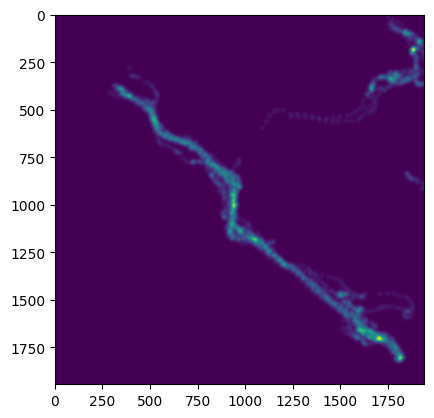

In [35]:
trail_map.min()

1.329515065184205e-269

In [36]:
8*60*10

4800

In [46]:
# get centroid distance matrix
def get_centroid_distance_matrix(tracks):
    '''
    Get the centroid distance matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # create an empty distance matrix
    distance_matrix = np.zeros((n_tracks, n_tracks))
    # calculate the distance between each pair of tracks
    for i in range(n_tracks):
        for j in range(n_tracks):
            if i == j:
                distance_matrix[i, j] = np.inf
            distance_matrix[i, j] = distance.euclidean(tracks[i].iloc[-1][['centroid.x', 'centroid.y']].values, tracks[j].iloc[0][['centroid.x', 'centroid.y']].values)
    return distance_matrix

# get the time difference matrix
def get_time_difference_matrix(tracks):
    '''
    Get the time difference matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # create an empty time difference matrix
    time_matrix = np.zeros((n_tracks, n_tracks))
    # calculate the time difference between each pair of tracks
    for i in range(n_tracks):
        for j in range(n_tracks):
            time_matrix[i, j] = tracks[j].iloc[0]['time'] - tracks[i].iloc[-1]['time']
            # if the time difference is negative, set it to infinity
            if time_matrix[i, j] < 0:
                time_matrix[i, j] = np.inf
    return time_matrix

# get the cost matrix
def get_cost_matrix(tracks, distance_limit=1, time_limit=0.5, body_pose_markers=['ovipositor', 'tip_of_head']):
    '''
    Get the cost matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # get the average maximum body length
    body_lengths = []
    for track in tracks:
        x_diff = track[body_pose_markers[1] + '.x'] - track[body_pose_markers[0] + '.x']
        y_diff = track[body_pose_markers[1] + '.y'] - track[body_pose_markers[0] + '.y']
        body_lengths.append(np.nanmax(np.sqrt(x_diff**2 + y_diff**2)))
    body_length = np.nanmean(body_lengths)
    # convert the distance limit to pixels
    distance_limit = distance_limit * body_length
    # create an empty cost matrix
    cost_matrix = np.zeros((n_tracks, n_tracks))
    # get the centroid distance matrix
    distance_matrix = get_centroid_distance_matrix(tracks)
    # get the time difference matrix
    time_matrix = get_time_difference_matrix(tracks)
    # calculate the cost matrix
    for i in range(n_tracks):
        for j in range(n_tracks):
            if distance_matrix[i, j] < distance_limit and time_matrix[i, j] < time_limit:
                cost_matrix[i, j] = distance_matrix[i, j] + time_matrix[i, j]
            else:
                cost_matrix[i, j] = np.inf
    return cost_matrix

In [55]:
# get the cost matrix for the tracks of the first video
cost_matrix = get_cost_matrix(database[list(database.keys())[0]]['tracks'])
# plot the cost matrix
plt.imshow(cost_matrix, cmap='cool')
plt.colorbar()
plt.xlabel('Track')
plt.ylabel('Track')
plt.title('Cost matrix')
plt.show()

In [56]:
# for each track, get the best matching track to find any sequential tracks
matches = []
for i in range(cost_matrix.shape[0]):
    j = np.argmin(cost_matrix[i])
    if cost_matrix[i, j] < np.inf:
        matches.append((i, j))
print(matches)

[(2, 3), (3, 4), (8, 9), (10, 41), (12, 60), (21, 22), (30, 31), (32, 44), (35, 51), (43, 44), (47, 48), (50, 31), (51, 52), (77, 78), (78, 79), (89, 90), (90, 91), (95, 96), (101, 102), (107, 108), (110, 111), (116, 117), (117, 118), (129, 130), (133, 146), (142, 138), (145, 146)]


In [54]:
sequential_matches

[]